<a href="https://colab.research.google.com/github/d4rkl0rd3r3b05/AutoSuggestionTableViewController/blob/master/Digit_Recognizer_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Integrating Kaggle with collab

In [2]:
from pathlib import Path

# installing kaggle package
if not(Path("kaggle.json").is_file()):
  !pip install -q kaggle

  # importing kaggle api file
  from google.colab import files
  files.upload()

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  !chmod 600 ~/.kaggle/kaggle.json

# making res call from kaggle
!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
stealthtechnologies/predict-student-performance-dataset          Predict Student Performance                          12KB  2024-12-26 12:57:04           1743         45  1.0              
anandshaw2001/mobile-apps-screentime-analysis                    Mobile Apps ScreenTime Analysis                       2KB  2024-12-31 18:20:51            700         24  1.0              
oktayrdeki/heart-disease                                         Heart Disease                                       568KB  2024-12-29 13:26:49           1423         37  1.0              
ankushpanday1/heart-a

## Packages Import

In [7]:
## Install missing packages
!pip install -q torchmetrics

try:
  import torchinfo
except:
  !pip install -q torchinfo

from torchinfo import summary

In [8]:
# torch essentials
import torch
from torch import nn
from torch import optim

# basic ops
import math
import numpy as np
from pathlib import Path
import requests


# util packages
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm


# visualize
import matplotlib.pyplot as plt
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix


# Torch metric
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix

# Torch Vision
from torchvision.transforms import ToTensor
import torchvision.transforms as T

## Step 1 - Downloading the train and test data from Kaggle

In [9]:
if not(Path("digit-recognizer.zip").is_file()):
  !kaggle competitions download -c 'digit-recognizer'
  !unzip "digit-recognizer.zip" -d "sample_data/digit-recognizer"

 33% 5.00M/15.3M [00:00<00:00, 27.0MB/s]
100% 15.3M/15.3M [00:00<00:00, 68.1MB/s]
Archive:  digit-recognizer.zip
  inflating: sample_data/digit-recognizer/sample_submission.csv  
  inflating: sample_data/digit-recognizer/test.csv  
  inflating: sample_data/digit-recognizer/train.csv  


## Step 2 - Analyze the train data

### Step 2.1 - Create dataframes from the data csv

In [10]:
import pandas as pd


train_data_path = Path("sample_data/digit-recognizer/train.csv")
test_data_path = Path("sample_data/digit-recognizer/test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head(), test_data.head()

(   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
 0      1       0       0       0       0       0       0       0       0   
 1      0       0       0       0       0       0       0       0       0   
 2      1       0       0       0       0       0       0       0       0   
 3      4       0       0       0       0       0       0       0       0   
 4      0       0       0       0       0       0       0       0       0   
 
    pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0         0         0         0   
 3       0  ...         0         0         0         0         0         0   
 4       0  ...         0         0         0         0         0         0   
 
    pixel780  pixel781  pixel782  pixel783  
 0         0   

### Step 2.2 - Visualize the data

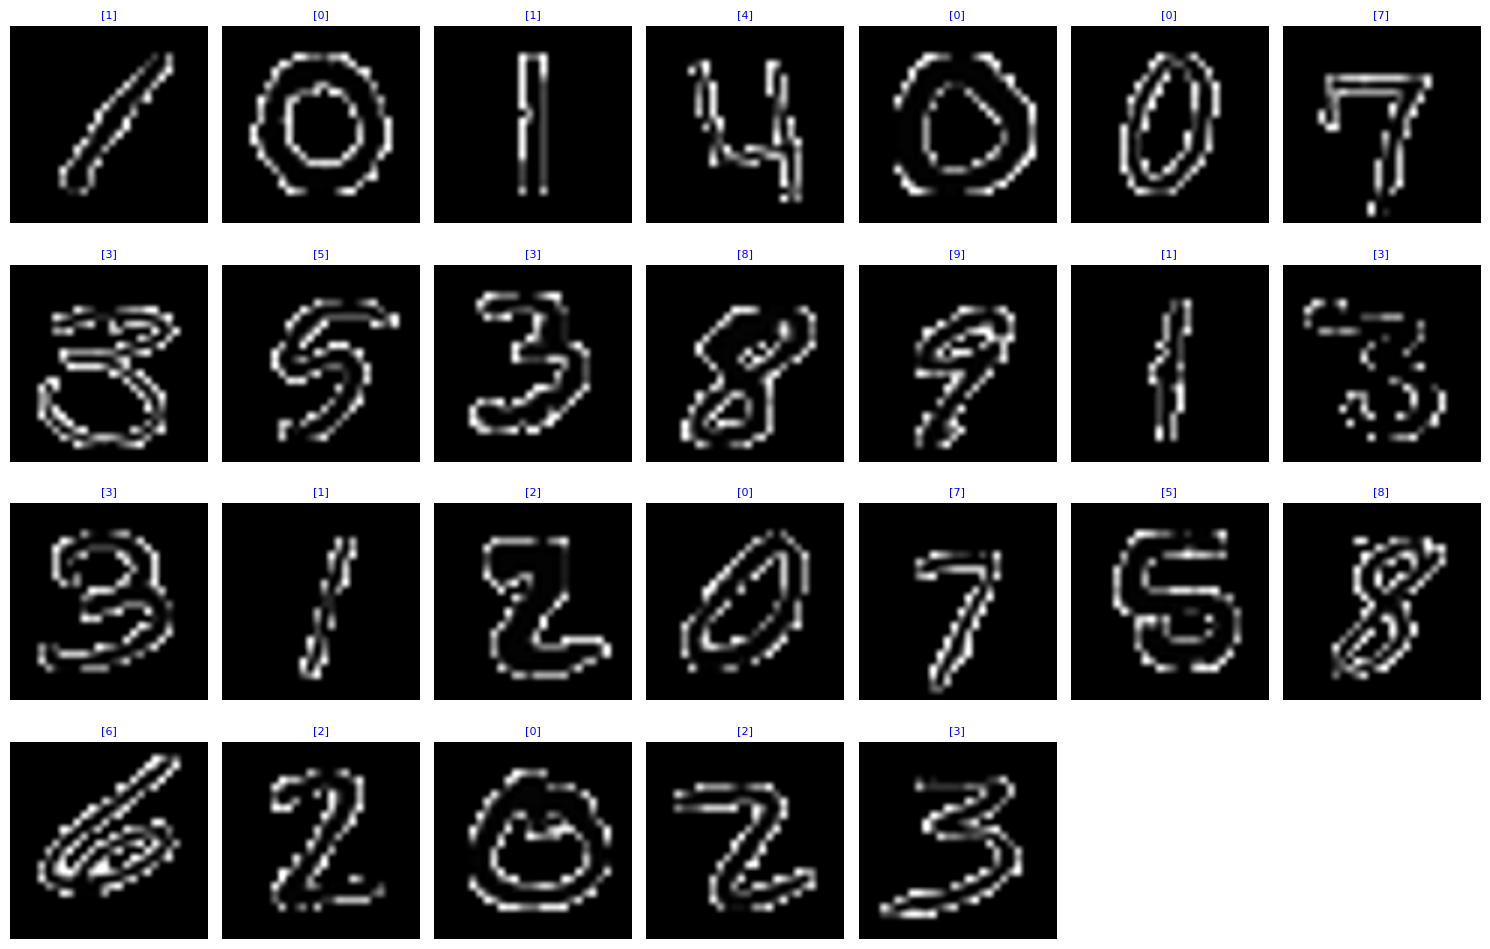

In [18]:
def plot_image_grid(X, y, pred=None, rows=4):
  """ Function to plot a grid of images with respective titles """

  fig = plt.figure(figsize=(15,10))

  number_of_images = len(y)
  columns = math.ceil(number_of_images/rows)

  for index in range(1, number_of_images+1):
    fig.add_subplot(rows, columns, index)

    img = torch.Tensor(X[index-1]).reshape([28, 28])
    transformer = T.ToPILImage()
    img_scaled = transformer(img).resize((160, 160))

    label = y[index-1]
    pred_label = "" if pred is None else pred[index-1]

    plt.imshow(img_scaled, cmap='gray')

    if pred is None:
      plt.title(label, fontsize=8, c='b', wrap=True)
    else:
      if pred_label ==  label :
        plt.title(f"True:{label}| Pred:{pred_label}", fontsize=8, c='g', wrap=True)
      else:
        plt.title(f"True:{label}| Pred:{pred_label}", fontsize=8, c='r', wrap=True)


    plt.axis(False)
    fig.subplots_adjust(top=1)
    fig.tight_layout()

plot_image_grid((train_data.loc[:25, train_data.columns!='label']).to_numpy(), (train_data.loc[:25, train_data.columns=='label']).to_numpy())


## Step 3 - Preprocess the train data(including split the train data in test-train)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.loc[:, train_data.columns!='label'], train_data[["label"]],test_size=0.33, random_state=42)
digit_classes = (train_data["label"]).unique()

### Step 3.2 - Create Dataset and DataLoader

In [12]:
class DigitRecognizerDataset(Dataset):
  def __init__(self, images, labels):
    super().__init__()

    self.images = images
    self.labels = labels

  def __getitem__(self, index):
    img = torch.Tensor(self.images[index]).reshape([1, 28, 28])

    return img, self.labels[index]

  def __len__(self):
    return len(self.labels)



train_dataset_custom = DigitRecognizerDataset(images=X_train.to_numpy(), labels=y_train.squeeze(1).to_numpy())
test_dataset_custom = DigitRecognizerDataset(images=X_test.to_numpy(), labels=y_test.squeeze(1).to_numpy())

train_dataloader_custom = DataLoader(dataset=train_dataset_custom, batch_size=5, shuffle=False)
test_dataloader_custom = DataLoader(dataset=test_dataset_custom, batch_size=5, shuffle=False)

## Step 4 - Define a model class, optimizer and criterion

In [13]:
class DigitRecognizer(nn.Module):
     def __init__(self, input_features, output_features, hidden_nodes=16):
       super().__init__()

       self.block_1 = nn.Sequential(
           nn.Conv2d(input_features, hidden_nodes, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2, stride=2)
       )

       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(in_features=hidden_nodes * 14 * 14, out_features=output_features)
       )


     def forward(self, x: torch.tensor) -> torch.tensor:
       x = self.block_1(x)
       return self.classifier(x)

classifier = DigitRecognizer(input_features=1, output_features=len(digit_classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=classifier.parameters(), lr=0.01)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(digit_classes))

## Step 5 - Train model

### Step 5.1 - Deine Train and Evaluation loops

In [14]:
# Training Loop
def train_step(model: nn.Module,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               dataloader: torch.utils.data.DataLoader):

  total_loss, total_accuracy = 0, 0
  for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
    model.train()

    pred = model(X)

    # print(f"PREDICTION ***: {pred} & Y ****: {y}" )


    loss = criterion(pred, y)
    accuracy = accuracy_fn(pred, y)

    total_loss += loss
    total_accuracy += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 200 == 0:
      print(f"Training for Batch: {batch} | Loss: {loss} | Accuracy: {accuracy*100:.2f}")

  avg_loss = total_loss/len(dataloader)
  avg_accuracy = total_accuracy/len(dataloader)
  print(f"Training complete with Average Total Loss: {avg_loss} & Average Total Accuracy: {avg_accuracy*100:.2f}" )

  return (avg_loss, avg_accuracy)

# Testing Loop
def test_step(model: nn.Module,
              criterion: nn.Module,
              accuracy_fn,
              dataloader: torch.utils.data.DataLoader):

  model.eval()
  with torch.inference_mode():
    total_loss, total_accuracy = 0, 0
    pred_labels = []
    for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
      pred_logits = model(X)
      pred = pred_logits.argmax(dim=1)
      pred_labels.append(pred)


      loss = criterion(pred_logits, y)
      accuracy = accuracy_fn(pred_logits, y)

      total_loss += loss
      total_accuracy += accuracy

    avg_loss = total_loss/len(dataloader)
    avg_accuracy = total_accuracy/len(dataloader)
    print(f"Testing complete with Average Total Loss: {avg_loss} & Average Total Accuracy: {avg_accuracy*100:.2f}" )

    return (avg_loss, avg_accuracy, pred_labels)

### checking values

In [ ]:
next(iter(train_dataloader_custom))[0][0].shape, next(iter(train_dataloader_custom))[1].shape

# plot_image_grid(next(iter(train_dataloader_custom))[0], next(iter(train_dataloader_custom))[1])

# plot_image_grid((train_data.loc[:25, train_data.columns!='label']).to_numpy(), (train_data.loc[:25, train_data.columns=='label']).to_numpy())plot_image_grid((train_data.loc[:25, train_data.columns!='label']).to_numpy(), (train_data.loc[:25, train_data.columns=='label']).to_numpy())

# plot_image_grid(X_train[:5].to_numpy(), y_train[:5].squeeze(1).to_numpy())
# X_train.loc[:25, :], y_train.loc[:25]


# (train_data.loc[:5, train_data.columns!='label']).to_numpy().shape, (X_train.loc[:3, :]).to_numpy().shape
# print((X_train[:3]).shape)

# classifier.eval()
# with torch.inference_mode():
#   pred = classifier(torch.Tensor(X_train[:1].to_numpy().reshape([1, 28, 28])))

# loss = criterion(pred, y_train[:1])

# torch.Tensor(X_train[:1].to_numpy().reshape([1, 28, 28]))

pred = classifier(next(iter(train_dataloader_custom))[0][0])


### Step 5.2 - Execute train and evaluation loops[link text](https://)

In [15]:
EPOCH = 10

start_time = timer()

total_train_loss, total_train_accuracy = 0, 0
total_test_loss, total_test_accuracy = 0, 0

#Create empty results dictionary
results = {"train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for index in range(EPOCH):
  total_train_loss, total_train_accuracy = train_step(classifier,
                                                      criterion = criterion,
                                                      optimizer=optimizer,
                                                      accuracy_fn=accuracy_fn,
                                                      dataloader=train_dataloader_custom)

  total_test_loss, total_test_accuracy, pred_labels = test_step(classifier,
                                                                criterion = criterion,
                                                                accuracy_fn=accuracy_fn,
                                                                dataloader=test_dataloader_custom)

  results["train_loss"].append(total_train_loss.item() if isinstance(total_train_loss, torch.Tensor) else total_train_loss)
  results["train_acc"].append(total_train_accuracy.item() if isinstance(total_train_accuracy, torch.Tensor) else total_train_accuracy)
  results["test_loss"].append(total_test_loss.item() if isinstance(total_test_loss, torch.Tensor) else total_test_loss)
  results["test_acc"].append(total_test_accuracy.item() if isinstance(total_test_accuracy, torch.Tensor) else total_test_accuracy)


end_time = timer()

print(f"Modelling complete in {end_time-start_time}")
print(f"Train Results: Train Total Loss: {total_train_loss} & Train Total Accuracy: {total_train_accuracy*100:.2f}" )
print(f"Train Results: Test Total Loss: {total_test_loss} & Test Total Accuracy: {total_test_accuracy*100:.2f}" )

  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 48.4283561706543 | Accuracy: 0.00
Training for Batch: 200 | Loss: 2.3492064476013184 | Accuracy: 20.00
Training for Batch: 400 | Loss: 2.1934216022491455 | Accuracy: 0.00
Training for Batch: 600 | Loss: 2.114773988723755 | Accuracy: 20.00
Training for Batch: 800 | Loss: 0.1957024186849594 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.7632762789726257 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.21294093132019043 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.642030119895935 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.4896731376647949 | Accuracy: 80.00
Training for Batch: 1800 | Loss: 0.7935816049575806 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.26880890130996704 | Accuracy: 80.00
Training for Batch: 2200 | Loss: 0.38346701860427856 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.1720627099275589 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.3803933560848236 | Accuracy: 80.00
Training for Batch: 2800 |

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.5843797922134399 & Average Total Accuracy: 81.41


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.7436681389808655 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.12181836366653442 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.1506702899932861 | Accuracy: 60.00
Training for Batch: 600 | Loss: 1.6307216882705688 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.033565811812877655 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.3612160086631775 | Accuracy: 100.00
Training for Batch: 1200 | Loss: 0.06447219848632812 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.7188060283660889 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.23988911509513855 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.7058765292167664 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.18516544997692108 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.1815689355134964 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.09977547824382782 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.23323412239551544 | Accuracy: 100.00
Training f

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.4866282045841217 & Average Total Accuracy: 84.81


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.6349700689315796 | Accuracy: 80.00
Training for Batch: 200 | Loss: 0.11954130977392197 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.0405689477920532 | Accuracy: 60.00
Training for Batch: 600 | Loss: 1.5847598314285278 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.03144612908363342 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.35557740926742554 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.04996345564723015 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.66008722782135 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.2106698453426361 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.6459397673606873 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.15610411763191223 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.13242824375629425 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.09062382578849792 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.20892298221588135 | Accuracy: 100.00
Training for 

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.4569951891899109 & Average Total Accuracy: 85.85


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.612811267375946 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.0862928032875061 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.2117602825164795 | Accuracy: 40.00
Training for Batch: 600 | Loss: 1.5440424680709839 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.03544780984520912 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.3347417116165161 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.053129684180021286 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.5521681308746338 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.15454058349132538 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.611029863357544 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.14914771914482117 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.14283514022827148 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.10652301460504532 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.20064203441143036 | Accuracy: 100.00
Training for 

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.4394913911819458 & Average Total Accuracy: 86.38


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.5935996174812317 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.08428789675235748 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.2533413171768188 | Accuracy: 40.00
Training for Batch: 600 | Loss: 1.5829486846923828 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.034793056547641754 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.3430587351322174 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.05347397178411484 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.5162432193756104 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.12631919980049133 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.564001202583313 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.17382082343101501 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.15051059424877167 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.11020682007074356 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.1946142613887787 | Accuracy: 100.00
Training for

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.43595513701438904 & Average Total Accuracy: 86.57


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.5938771367073059 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.08134898543357849 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.2889379262924194 | Accuracy: 40.00
Training for Batch: 600 | Loss: 1.5504059791564941 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.03958972543478012 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.31405559182167053 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.05161995813250542 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.7012754678726196 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.13777388632297516 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.6373069286346436 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.14352694153785706 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.10059203952550888 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.109397754073143 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.1957697719335556 | Accuracy: 100.00
Training for 

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.43164485692977905 & Average Total Accuracy: 86.68


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.5777783989906311 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.14683936536312103 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.2060024738311768 | Accuracy: 60.00
Training for Batch: 600 | Loss: 1.536214828491211 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.0361652597784996 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.32026156783103943 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.050024550408124924 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.7210910320281982 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.13188090920448303 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.5824841260910034 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.1743081510066986 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.11085718870162964 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.11773797124624252 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.1856376677751541 | Accuracy: 100.00
Training for 

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.42877259850502014 & Average Total Accuracy: 86.65


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.5905994176864624 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.0750051885843277 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.3642232418060303 | Accuracy: 40.00
Training for Batch: 600 | Loss: 1.5358587503433228 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.04008162394165993 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.3143758177757263 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.05336233973503113 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.6790939569473267 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.11001043021678925 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.5766656398773193 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.16503694653511047 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.09262926131486893 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.1107020229101181 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.1872718632221222 | Accuracy: 100.00
Training for B

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.42884501814842224 & Average Total Accuracy: 86.83


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.5989438891410828 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.07236562669277191 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.3900889158248901 | Accuracy: 40.00
Training for Batch: 600 | Loss: 1.5629441738128662 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.03567193076014519 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.31675395369529724 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.0536365807056427 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.6981284618377686 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.10631905496120453 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.5552664995193481 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.17695513367652893 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.1039724349975586 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.10349799692630768 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.18578162789344788 | Accuracy: 100.00
Training for

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.43065643310546875 & Average Total Accuracy: 86.78


  0%|          | 0/5628 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.5902515649795532 | Accuracy: 60.00
Training for Batch: 200 | Loss: 0.07163527607917786 | Accuracy: 100.00
Training for Batch: 400 | Loss: 1.4004682302474976 | Accuracy: 60.00
Training for Batch: 600 | Loss: 1.5630395412445068 | Accuracy: 60.00
Training for Batch: 800 | Loss: 0.03624560683965683 | Accuracy: 100.00
Training for Batch: 1000 | Loss: 0.31771597266197205 | Accuracy: 80.00
Training for Batch: 1200 | Loss: 0.05085979774594307 | Accuracy: 100.00
Training for Batch: 1400 | Loss: 1.701241135597229 | Accuracy: 60.00
Training for Batch: 1600 | Loss: 0.10138829797506332 | Accuracy: 100.00
Training for Batch: 1800 | Loss: 0.5548888444900513 | Accuracy: 80.00
Training for Batch: 2000 | Loss: 0.1799294352531433 | Accuracy: 100.00
Training for Batch: 2200 | Loss: 0.10386510193347931 | Accuracy: 100.00
Training for Batch: 2400 | Loss: 0.10634424537420273 | Accuracy: 100.00
Training for Batch: 2600 | Loss: 0.19294001162052155 | Accuracy: 100.00
Training for

  0%|          | 0/2772 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.4256705045700073 & Average Total Accuracy: 86.72
Modelling complete in 329.515195793
Train Results: Train Total Loss: 0.3780844211578369 & Train Total Accuracy: 88.45
Train Results: Test Total Loss: 0.4256705045700073 & Test Total Accuracy: 86.72


## Step 6 - Make prediction

In [16]:
def predict_labels(model: nn.Module, dataloader: DataLoader):
  model.eval()
  predictions = []
  with torch.inference_mode():
    for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
      pred_logits = model(X)
      pred = pred_logits.argmax(dim=1)
      predictions.extend(pred.tolist())
  return predictions

test_dataset_custom_complete = DigitRecognizerDataset(images=test_data.to_numpy(), labels=np.zeros(len(test_data)))
test_dataloader_custom_complete = DataLoader(dataset=test_dataset_custom_complete, batch_size=5, shuffle=False)

test_predictions = predict_labels(classifier, test_dataloader_custom_complete)

  0%|          | 0/5600 [00:00<?, ?it/s]

## Step 7 - Post Process the prediction in the required format for submission

### Step 7.1 - Visualize the predicted values

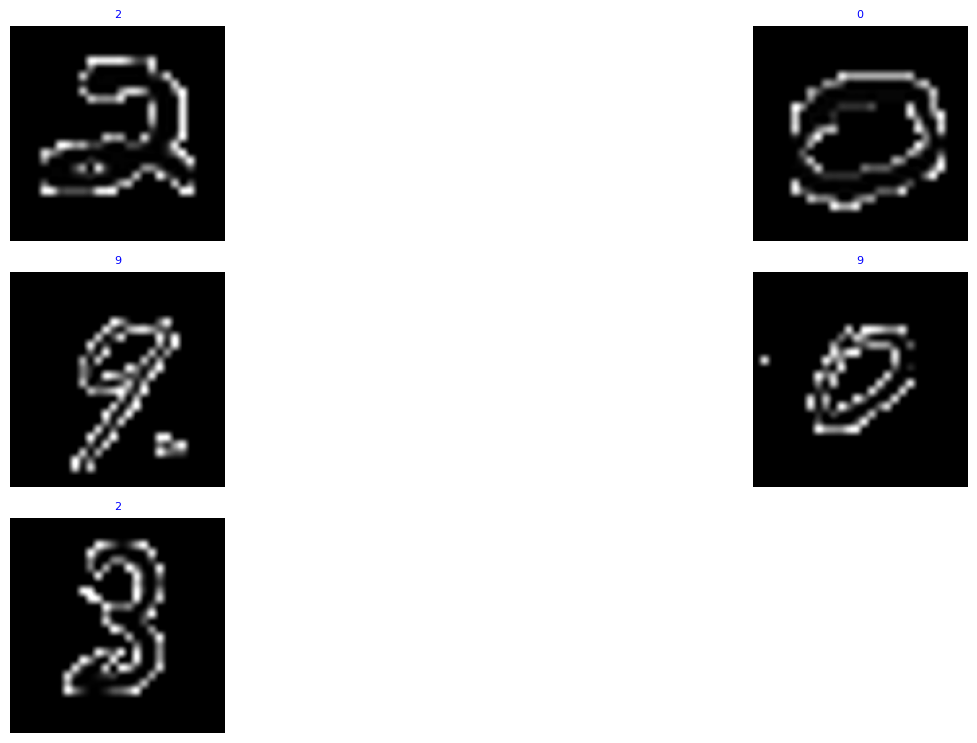

In [23]:
plot_image_grid(test_data[:5].to_numpy(), np.array(test_predictions[:5]))

### Step 7.2 - Creating submission csv

In [ ]:
submission = pd.DataFrame({'ImageId': range(1, len(test_predictions) + 1), 'Label': test_predictions})
submission.to_csv('submission.csv', index=False)